![Deep Learning for Scientists in a hurry](./fig/Title.png)

In [ ]:
%load_ext watermark

In [2]:
%watermark

Last updated: 2023-07-24T23:26:08.182190-04:00

Python implementation: CPython
Python version       : 3.10.6
IPython version      : 8.14.0

Compiler    : GCC 11.3.0
OS          : Linux
Release     : 3.10.0-1160.24.1.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 52
Architecture: 64bit



In [3]:
import time
start = time.time()
chapter_number = 5
import matplotlib
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt

In [4]:
import numpy as np
import torch

In [5]:
%watermark -iv

numpy     : 1.22.2
torch     : 2.1.0a0+4136153
matplotlib: 3.7.1



# Convolutional Neural Networks with PyTorch

Until now we have to build Neural Networks where the deeper layers are connected densely to the outputs of the previous layer.

When we were using the MNIST dataset, the $28 \times 28$ grid of pixels were flattened to a single list of values.
Doing that was good because it allow us to consider each pixel individually as a neuron and the network was in charge of the tasks of optimizing the weights that could identify digits correctly.

However, the flattening also was unfortunate because we lost the natural idea of dealing with an image where there the pixels have a grid-like arrange in space. 

Convolutional Neural Networks have been very successfully used in applications with visual perceptual problems, being those images or even video.

## The MNIST dataset

The MNIST dataset contains $70,000$ images with handwritten single digits. The images are $28 \times 28$ pixels. Pytorch sub package torchvision provides a method to download the MNIST dataset. The dataset must be downloaded in advance on a machine with internet access. 

In [6]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets,transforms
from torch.autograd import Variable

Let's check if the notebook is running on a machine with CUDA enabled.

In [7]:
is_cuda=False
if torch.cuda.is_available():
    is_cuda = True

In [8]:
transformation = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))])

train_dataset = datasets.MNIST('./data/',train=True,transform=transformation,download=False)
test_dataset = datasets.MNIST('./data/',train=False,transform=transformation,download=False)

train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=32,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=32,shuffle=True)

In [9]:
sample_data = next(iter(train_loader))

In [10]:
test_dataset

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data/
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )

In [11]:
def show_one(image):
    image = image.numpy()[0]
    plt.imshow(image,cmap='gray', interpolation='none')

In [12]:
sample_data[0].shape

torch.Size([32, 1, 28, 28])

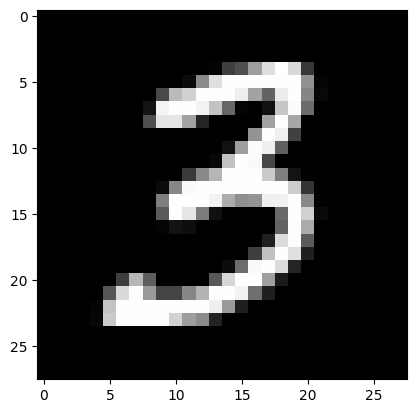

In [13]:
show_one(sample_data[0][0])

In [14]:
def show_batch(sample_data):
    images=sample_data[0]
    fig, axs = plt.subplots(4, 8, sharex=True, sharey=True, figsize=(12,6))
    for i in range(4):
        for j in range(8):
            axs[i,j].imshow(images[4*j+i].numpy()[0],cmap='gray', interpolation='none')

In [15]:
sample_data[0][0].shape

torch.Size([1, 28, 28])

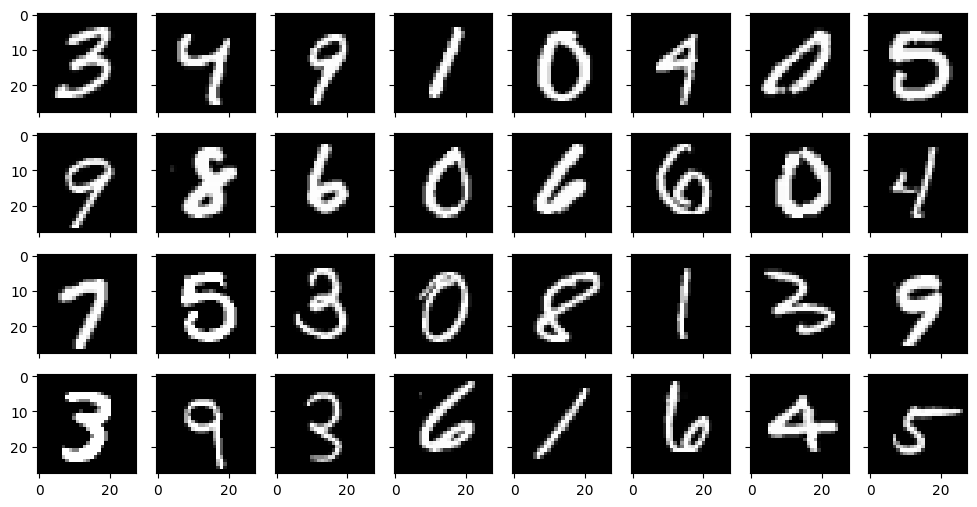

In [16]:
show_batch(sample_data)

In [17]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        #x = F.dropout(x,p=0.1, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x,dim=1)

In [18]:
model = Net()
if is_cuda:
    model.cuda()

In [19]:
is_cuda

True

In [20]:
optimizer = optim.SGD(model.parameters(),lr=0.01)

In [21]:
data , target = next(iter(train_loader))

In [22]:
if is_cuda:
    output = model(Variable(data.cuda()))
else:
    output = model(Variable(data))

In [23]:
output.size()

torch.Size([32, 10])

In [24]:
target.size()

torch.Size([32])

In [25]:
def fit(epoch,model,data_loader,phase='training',volatile=False):
    if phase == 'training':
        model.train()
    if phase == 'validation':
        model.eval()
        volatile=True
    running_loss = 0.0
    running_correct = 0
    for batch_idx , (data,target) in enumerate(data_loader):
        if is_cuda:
            data,target = data.cuda(),target.cuda()
        data , target = Variable(data,volatile),Variable(target)
        if phase == 'training':
            optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output,target)
        
        running_loss += F.nll_loss(output,target,reduction='sum').item()
        preds = output.data.max(dim=1,keepdim=True)[1]
        running_correct += preds.eq(target.data.view_as(preds)).cpu().sum()
        if phase == 'training':
            loss.backward()
            optimizer.step()
    
    loss = running_loss/len(data_loader.dataset)
    accuracy = 100. * running_correct/len(data_loader.dataset)
    
    loss_phrase=f"{phase} loss : ".capitalize().ljust(19) 
    accuracy_phrase=f"{phase} accuracy : ".capitalize().ljust(22)
    
    print(f'{loss_phrase} {loss:{5}.{2}}   {accuracy_phrase} {running_correct:{7}}/{len(data_loader.dataset)}{accuracy:{10}.{4}} %')
    return loss,accuracy

In [26]:
train_losses , train_accuracy = [],[]
val_losses , val_accuracy = [],[]
for epoch in range(1,10):
    epoch_loss, epoch_accuracy = fit(epoch,model,train_loader,phase='training')
    val_epoch_loss , val_epoch_accuracy = fit(epoch,model,test_loader,phase='validation')
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

Training loss :      0.59   Training accuracy :      49274/60000     82.12 %
Validation loss :    0.16   Validation accuracy :     9547/10000     95.47 %
Training loss :       0.2   Training accuracy :      56548/60000     94.25 %
Validation loss :   0.097   Validation accuracy :     9694/10000     96.94 %
Training loss :      0.15   Training accuracy :      57310/60000     95.52 %
Validation loss :   0.068   Validation accuracy :     9785/10000     97.85 %
Training loss :      0.13   Training accuracy :      57808/60000     96.35 %
Validation loss :   0.064   Validation accuracy :     9789/10000     97.89 %
Training loss :      0.11   Training accuracy :      58005/60000     96.68 %
Validation loss :   0.058   Validation accuracy :     9825/10000     98.25 %
Training loss :       0.1   Training accuracy :      58201/60000      97.0 %
Validation loss :   0.051   Validation accuracy :     9828/10000     98.28 %
Training loss :     0.096   Training accuracy :      58319/60000      97.2 %

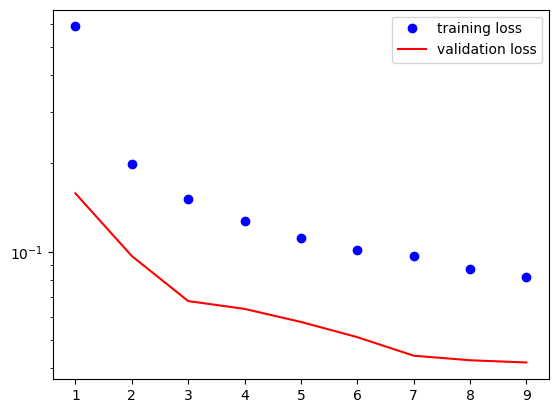

In [27]:
plt.semilogy(range(1,len(train_losses)+1),train_losses,'bo',label = 'training loss')
plt.semilogy(range(1,len(val_losses)+1),val_losses,'r',label = 'validation loss')
plt.legend();

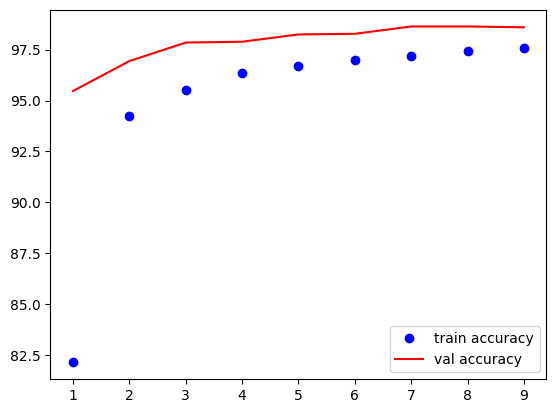

In [28]:
plt.plot(range(1,len(train_accuracy)+1),train_accuracy,'bo',label = 'train accuracy')
plt.plot(range(1,len(val_accuracy)+1),val_accuracy,'r',label = 'val accuracy')
plt.legend();

### 1D convolutions

In [29]:
conv = nn.Conv1d(1,1,3,bias=False)
conv

Conv1d(1, 1, kernel_size=(3,), stride=(1,), bias=False)

In [30]:
conv.weight

Parameter containing:
tensor([[[-0.0951,  0.2767, -0.5385]]], requires_grad=True)

In [31]:
sample = torch.randn(1,1,7)
sample

tensor([[[-0.6611, -1.7917, -0.2933,  1.6056,  0.8148,  0.3630,  2.0784]]])

In [32]:
conv(Variable(sample))

tensor([[[-0.2749, -0.7753,  0.0334, -0.1227, -1.0962]]],
       grad_fn=<ConvolutionBackward0>)

### 1D Convolutions with padding

In [33]:
conv = nn.Conv1d(1,1,3,padding=2,bias=False)
conv

Conv1d(1, 1, kernel_size=(3,), stride=(1,), padding=(2,), bias=False)

In [34]:
conv.weight

Parameter containing:
tensor([[[-0.3842, -0.0351, -0.1649]]], requires_grad=True)

In [35]:
sample = torch.randn(1,1,7)
sample

tensor([[[-0.2875,  0.7275,  0.0885, -1.2549, -1.5204, -0.8674, -0.3325]]])

In [36]:
conv(Variable(sample))

tensor([[[ 0.0474, -0.1098,  0.0704, -0.0757,  0.2606,  0.6785,  0.6694,
           0.3450,  0.1278]]], grad_fn=<ConvolutionBackward0>)

---

# References

There are many books about Deep Learning and many more on Machine Learning. 
This list is by no means an exhaustive list of books. I am listing the books from which I took inspiration. Also, I am listing materials where I found better ways to present topics. Often I am amazed by how people can create approachable materials for seemingly dry subjects.

The order of the books goes from divulgation and practical to the more rigorous and mathematical. Slides, blogs, and videos are those I have found over the internet or suggested by others.

### Selection of Books on Deep Learning

<br>
<div style="clear: both; display: table;">
  <div style="border: none; float: left; width: 200; padding: 5px">
  <img alt="Deep Learning - Kelleher" 
       src="./fig/books/Deep Learning - Kelleher.jpg" 
       height="100" width="100"  />
  </div>
  <div style="border: none; float: left; width: 800; padding: 5px">
      Deep Learning<br>
      John D. Kelleher<br>
      2019<br>
  </div>
</div>

<br>
<div style="clear: both; display: table;">
  <div style="border: none; float: left; width: 200; padding: 5px">
  <img alt="Introduction to Deep Learning - Charniak" 
       src="./fig/books/Introduction to Deep Learning - Charniak.jpg" 
       height="100" width="100"  />
  </div>
  <div style="border: none; float: left; width: 800; padding: 5px">
      Introduction to Deep Learning<br>
      Eugene Charniak<br>
      2018<br>
  </div>
</div>

<br>
<div style="clear: both; display: table;">
  <div style="border: none; float: left; width: 200; padding: 5px">
  <img alt="Introduction to Deep Learning - Skansi" 
       src="./fig/books/Introduction to Deep Learning - Skansi.jpg" 
       height="100" width="100"  />
  </div>
  <div style="border: none; float: left; width: 800; padding: 5px">
      Introduction to Deep Learning<br>
      Sandro Skansi<br>
      2018<br>
  </div>
</div>

<br>
<div style="clear: both; display: table;">
  <div style="border: none; float: left; width: 200; padding: 5px">
  <img alt="Deep Learning with PyTorch - Subramanian" 
       src="./fig/books/Deep Learning with PyTorch - Subramanian.jpg" 
       height="100" width="100"  />
  </div>
  <div style="border: none; float: left; width: 800; padding: 5px">
      Deep Learning with PyTorch<br>
      Vishnu Subramanian<br>
      2018<br>
  </div>
</div>

<br>
<div style="clear: both; display: table;">
  <div style="border: none; float: left; width: 200; padding: 5px">
  <img alt="Deep Learning with PyTorch - Stevens" 
       src="./fig/books/Deep Learning with PyTorch - Stevens.png" 
       height="100" width="100"  />
  </div>
  <div style="border: none; float: left; width: 800; padding: 5px">
      Deep Learning with PyTorch<br>
      Eli Stevens, Luca Artiga and Thomas Viehmann<br>
      2020<br>
  </div>
</div>

<br>
<div style="clear: both; display: table;">
  <div style="border: none; float: left; width: 200; padding: 5px">
  <img alt="Deep Learning with Python - Chollet" 
       src="./fig/books/Deep Learning with Python - Chollet.jpg" 
       height="100" width="100" />
  </div>
  <div style="border: none; float: left; width: 800; padding: 5px">
      Deep Learning with Python (Second Edition)<br>
      François Chollet<br>
      2021<br>
  </div>
</div>

<br>
<div style="clear: both; display: table;">
  <div style="border: none; float: left; width: 200; padding: 5px">
  <img alt="Deep Learning - Patterson" 
       src="./fig/books/Deep Learning - Patterson.jpeg"
       height="100" width="100" />
  </div>
  <div style="border: none; float: left; width: 800; padding: 5px">
      Deep Learning, a practitioner's approach<br>
      Josh Patterson and Adam Gibson<br>
      2017<br>
  </div>
</div>

<br>
<div style="clear: both; display: table;">
  <div style="border: none; float: left; width: 200; padding: 5px">
  <img alt="Deep Learning - Goodfellow" 
       src="./fig/books/Deep Learning - Goodfellow.jpg" 
       height="100" width="100"  />
  </div>
  <div style="border: none; float: left; width: 800; padding: 5px">
      Deep Learning<br>
      Ian Goodfellow, Yoshua Bengio, and Aaron Courville<br>
      2016<br>
  </div>
</div>

### Interactive Books

  * [Dive into Deep Learning](https://d2l.ai/index.html)<br>
    Interactive deep learning book with code, math, and discussions<br> 
    Implemented with PyTorch, NumPy/MXNet, and TensorFlow<br>
    Adopted at 300 universities from 55 countries


### Slides

  * John Urbanic's ["Deep Learning in one Afternoon"](https://www.psc.edu/wp-content/uploads/2022/04/Deep-Learning.pdf)<br>
An excellent fast, condensed introduction to Deep Learning.<br>
John is a Parallel Computing Scientist at Pittsburgh Supercomputing Center

  * [Christopher Olah's Blog](http://colah.github.io) is very good. For example about [Back Propagation](http://colah.github.io/posts/2015-08-Backprop)

  * Adam W. Harley on his CMU page offers [An Interactive Node-Link Visualization of Convolutional Neural Networks](https://www.cs.cmu.edu/~aharley/vis/)



### Jupyter Notebooks

 * [Yale Digital Humanities Lab](https://github.com/YaleDHLab/lab-workshops)
 
 * Aurelien Geron Hands-on Machine Learning with Scikit-learn 
   [First Edition](https://github.com/ageron/handson-ml) and
   [Second Edition](https://github.com/ageron/handson-ml2)
   
 * [A progressive collection notebooks of the Machine Learning course by the University of Turin](https://github.com/rugantio/MachineLearningCourse)
   
 * [A curated set of jupyter notebooks about many topics](https://github.com/jupyter/jupyter/wiki/A-gallery-of-interesting-Jupyter-Notebooks)
   
### Videos

 * [Caltech's "Learning from Data" by Professor Yaser Abu-Mostafa](https://work.caltech.edu/telecourse.html)
 
 * [3Blue1Brown Youtube Channel](https://www.youtube.com/watch?v=Ilg3gGewQ5U)
 
 ---

# Back of the Book

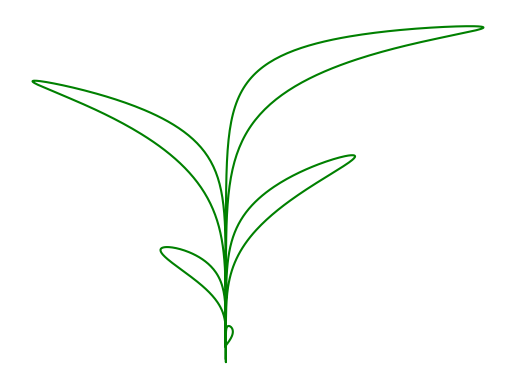

In [37]:
n = chapter_number
t = np.linspace(0, (2*(n-1)+1)*np.pi/2, 1000)
x = t*np.cos(t)**3
y = 9*t*np.sqrt(np.abs(np.cos(t))) + t*np.sin(0.3*t)*np.cos(2*t)
plt.plot(x, y, c="green")
plt.axis('off');

In [38]:
end = time.time()
print(f'Chapter {chapter_number} took {int(end - start):d} seconds')

Chapter 5 took 113 seconds
